In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import cmasher
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import metpy.calc as mpcalc
#from metpy.units import units
import os
import calendar

In [2]:
def gph_climo_plots(filepath, latitude, longitude):
    
    '''Creates 4 histograms of 500mb geopotential heights by month from 1979-2023 in any given grid cell from a 
    concatenated ERA5 NetCDF file and creates a plot of the climatological heights for the entire domain.
    Parameters:
    - filepath --> the path to one of the concatenated files that contains all height data for a given month.
    - latitude --> The latitude desired, must be within the bounds of the file
    - longitude --> The longitude desired, must be within the bounds of the file'''

    #open the concatenated dataset containing all data from 1979-2023 
    #select only the grid cell with the specified latitude and longitude for a histogram.
    data = xr.open_dataset(filepath)
    monthly_average = data.mean(dim = 'time')
    select_data = data.sel(latitude = latitude, longitude = longitude)

    #get latitude and longitude for the entire domain
    lons = data['longitude']
    lats = data['latitude']
    
    #convert to degrees west, more intuitive for the plots
    revised_lon = 360 - longitude

    #access the geopotential heights for the histogram based on the specifications above
    histogram_heights = select_data['z'][:]/9.81
    cartopy_heights = monthly_average['z']/9.81

    #number of hours in the dataset
    size = select_data['time'].size
    
    #number of bins for the histogram based on the square root rule
    num_bins = int(np.sqrt(size))

    #average geopotential height at the given coordinates to compare histogram/domain plot
    average_height = np.mean(histogram_heights).data

    #setup a figure with two subplots
    fig = plt.figure(figsize = (15,15))
    projection = ccrs.PlateCarree(central_longitude = 0)
    ax1 = fig.add_subplot(211, projection = projection)
    ax2 = fig.add_subplot(212)

    #Add some cartopy details to the plot of climatology
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.LAKES, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.OCEAN, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.STATES, linewidth = 0.5, edgecolor = 'black')

    #Add grid lines for latitude and longitude
    grid_lines = ax1.gridlines(draw_labels = True, xlocs = [-105, -95, -85, -75, -65], ylocs = [35,45,55], linestyle = '--', color = 'gray')
    grid_lines.xlabel_style = {'size': 10, 'color': 'black'}
    grid_lines.ylabel_style = {'size': 10, 'color': 'black'}

    #Get rid of grid line labels on the top and right of the plot
    grid_lines.top_labels = False 
    grid_lines.right_labels = False 
       
    #Setup the height contours, colors, and colorbar
    cf = ax1.contourf(lons, lats, cartopy_heights, cmap = cmasher.voltage)
    cbar = plt.colorbar(cf, pad = 0.01)
    cl = ax1.contour(cf, colors = 'k', linewidths = 0.5)
    cbar.add_lines(cl)
    cbar.set_label("Geopotential height (m)")

    #Add a marker to the first plot to see the selected coordinates
    ax1.plot(revised_lon*-1, latitude, 'w*', label = f'{latitude}$^\circ$N, {revised_lon}$^\circ$W', markersize = 10, zorder = 5)
    ax1.legend(loc = 'best')
    
    #create the histogram, set labels
    ax2.hist(histogram_heights, bins = num_bins, color = 'black')
    ax2.set_ylabel('Frequency')
    ax2.set_xlabel('Geopotential Height (m)')
    
    ax2.set_title(f'Histogram of heights at {latitude}$^\circ$N, {revised_lon}$^\circ$W, N = {size}, mean = {average_height:.0f}m')

    #Set up the function so that the figure automatically tells you which month you're looking at
    directory_parts = filepath.split('_')
    end = directory_parts[-1]
    end_parts = end.split('.')
    month = end_parts[0].capitalize()

    #Create the title
    fig.suptitle(f'{month} 500mb Heights Climatology from 1979 to 2023', fontsize = 20)
    fig.tight_layout()

In [3]:
#filepath = r"X:\dewhirst\500_heights_monthly_climo\concatenated_geopotential_files_for_october.nc"
#latitude = 43
#longitude = 277
#gph_climo_plots(filepath, latitude, longitude)

In [26]:
def plot_gph_histograms(folder, month):
    '''Create and store histograms of geopotential height climatology for every grid cell in the domain. The function will create 
    4 histograms in a single figure for randomly generated coordinates within the domain. This provides a sanity check for the data quality.
    Parameters:
    - folder --> string, the directory of the folder where the files are being stored. 
    - month --> number representing the month, zeropadded if single digit '''

    #The maximum and minimum coordinates in my domain
    lat_min, lat_max = 15, 55
    lon_min, lon_max = 250, 310
    
    # Generate 4 random pairs of coordinates
    num_pairs = 4
    random_lats = np.random.uniform(lat_min, lat_max, num_pairs)
    random_lons = np.random.uniform(lon_min, lon_max, num_pairs)

    #convert randomly generated coordinates to integers
    for i in range(4):
        random_lats[i] = int(random_lats[i])
        random_lons[i] = int(random_lons[i])

    # Combine into pairs
    random_coords = list(zip(random_lats, random_lons))

    #Create the figure for the cartopy plot
    projection = ccrs.PlateCarree(central_longitude = 0)
    fig1 = plt.figure(figsize = (12,9))
    fig1.suptitle(f'{month.capitalize()} 500mb Heights Climatology from 1979 to 2023', fontsize = 20, x = 0.47, y = 0.87)
    ax1 = fig1.add_subplot(111, projection = projection)

    #Create the figure for the histograms
    fig2, ax = plt.subplots(4, 1, figsize = (10,20))
    fig2.suptitle(f'Histograms of {month.capitalize()} 500mb geopotential heights at 4 randomly generated coordinates', x = 0.5, y = 1, fontsize = 17)
    fig2.tight_layout(h_pad = 3)

    #Search through the folder to find the files that contains the desired month's data, one for the histograms, the other for a cartopy map
    for filename in os.listdir(folder):
        if f'concatenated_era5_geopotential_{month}' in filename:
            histogram_data = xr.open_dataset(os.path.join(folder, filename))
            Lons = histogram_data['longitude']
            Lats = histogram_data['latitude']
        if f'avg_era5_geopotential_{month}' in filename:
            cartopy_data = xr.open_dataset(os.path.join(folder, filename))
            cartopy_heights = cartopy_data['z'][0]/9.81

    #Add some cartopy details to the first figure
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.LAKES, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.OCEAN, linewidth = 0.5, edgecolor = 'black')
    ax1.add_feature(cfeature.STATES, linewidth = 0.5, edgecolor = 'black')

    #Add grid lines for latitude and longitude
    grid_lines = ax1.gridlines(draw_labels = True, xlocs = [-105, -95, -85, -75, -65], ylocs = [35,45,55], linestyle = '--', color = 'white')
    grid_lines.xlabel_style = {'size': 10, 'color': 'black'}
    grid_lines.ylabel_style = {'size': 10, 'color': 'black'}

    #Get rid of grid line labels on the top and right of the plot
    grid_lines.top_labels = False 
    grid_lines.right_labels = False 

    levels = np.linspace(5000, 6000, 25)
       
    #Setup the height contours, colors, and colorbar
    cf = ax1.contourf(Lons, Lats, cartopy_heights, levels = levels, cmap = cmasher.voltage)
    cbar = plt.colorbar(cf, pad = 0.01, shrink = 0.72)
    cl = ax1.contour(cf, colors = 'k', linewidths = 0.5)
    cbar.add_lines(cl)
    cbar.set_label("Geopotential height (m)")

    #Now loop through the pairs of coordinates to create the subplot histograms
    for i, (latitude, longitude) in enumerate(random_coords):
        select_data = histogram_data.sel(latitude = latitude, longitude = longitude)
        histogram_heights = select_data['z']/9.81

        #Easier to understand in degrees west
        revised_lon = 360 - longitude

        #number of hours in the dataset
        size = select_data['time'].size
        
        #number of bins for the histogram based on the square root rule
        num_bins = int(np.sqrt(size))
    
        #average geopotential height at the given coordinates to compare histogram/domain plot
        average_height = np.mean(histogram_heights).data
        
        #create the histograms, set labels and titles
        ax[i].hist(histogram_heights, bins = num_bins, color = 'black')
        ax[i].set_ylabel('Frequency')
        ax[i].set_xlabel('Geopotential Height (m)')
        ax[i].set_title(f'All 500mb Heights at {latitude}$^\circ$N, {revised_lon}$^\circ$W, N = {size}, mean = {average_height:.0f}m')

        #For the first figure, display all coordinates as stars
        ax1.plot(revised_lon*-1, latitude, 'r*', label = f'{latitude}$^\circ$N, {revised_lon}$^\circ$W', markersize = 10, zorder = 5)
        ax1.text(revised_lon * -1 - 3.5, latitude + 0.8, f'{latitude}$^\circ$N, {revised_lon}$^\circ$W', color = 'white', 
                 fontsize = 10, weight='bold', zorder=10)

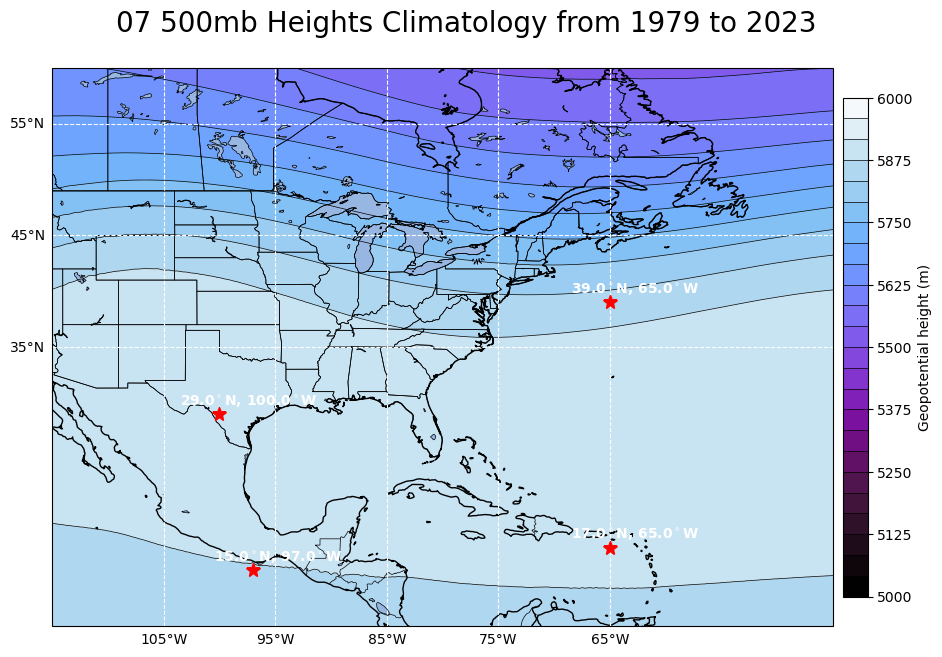

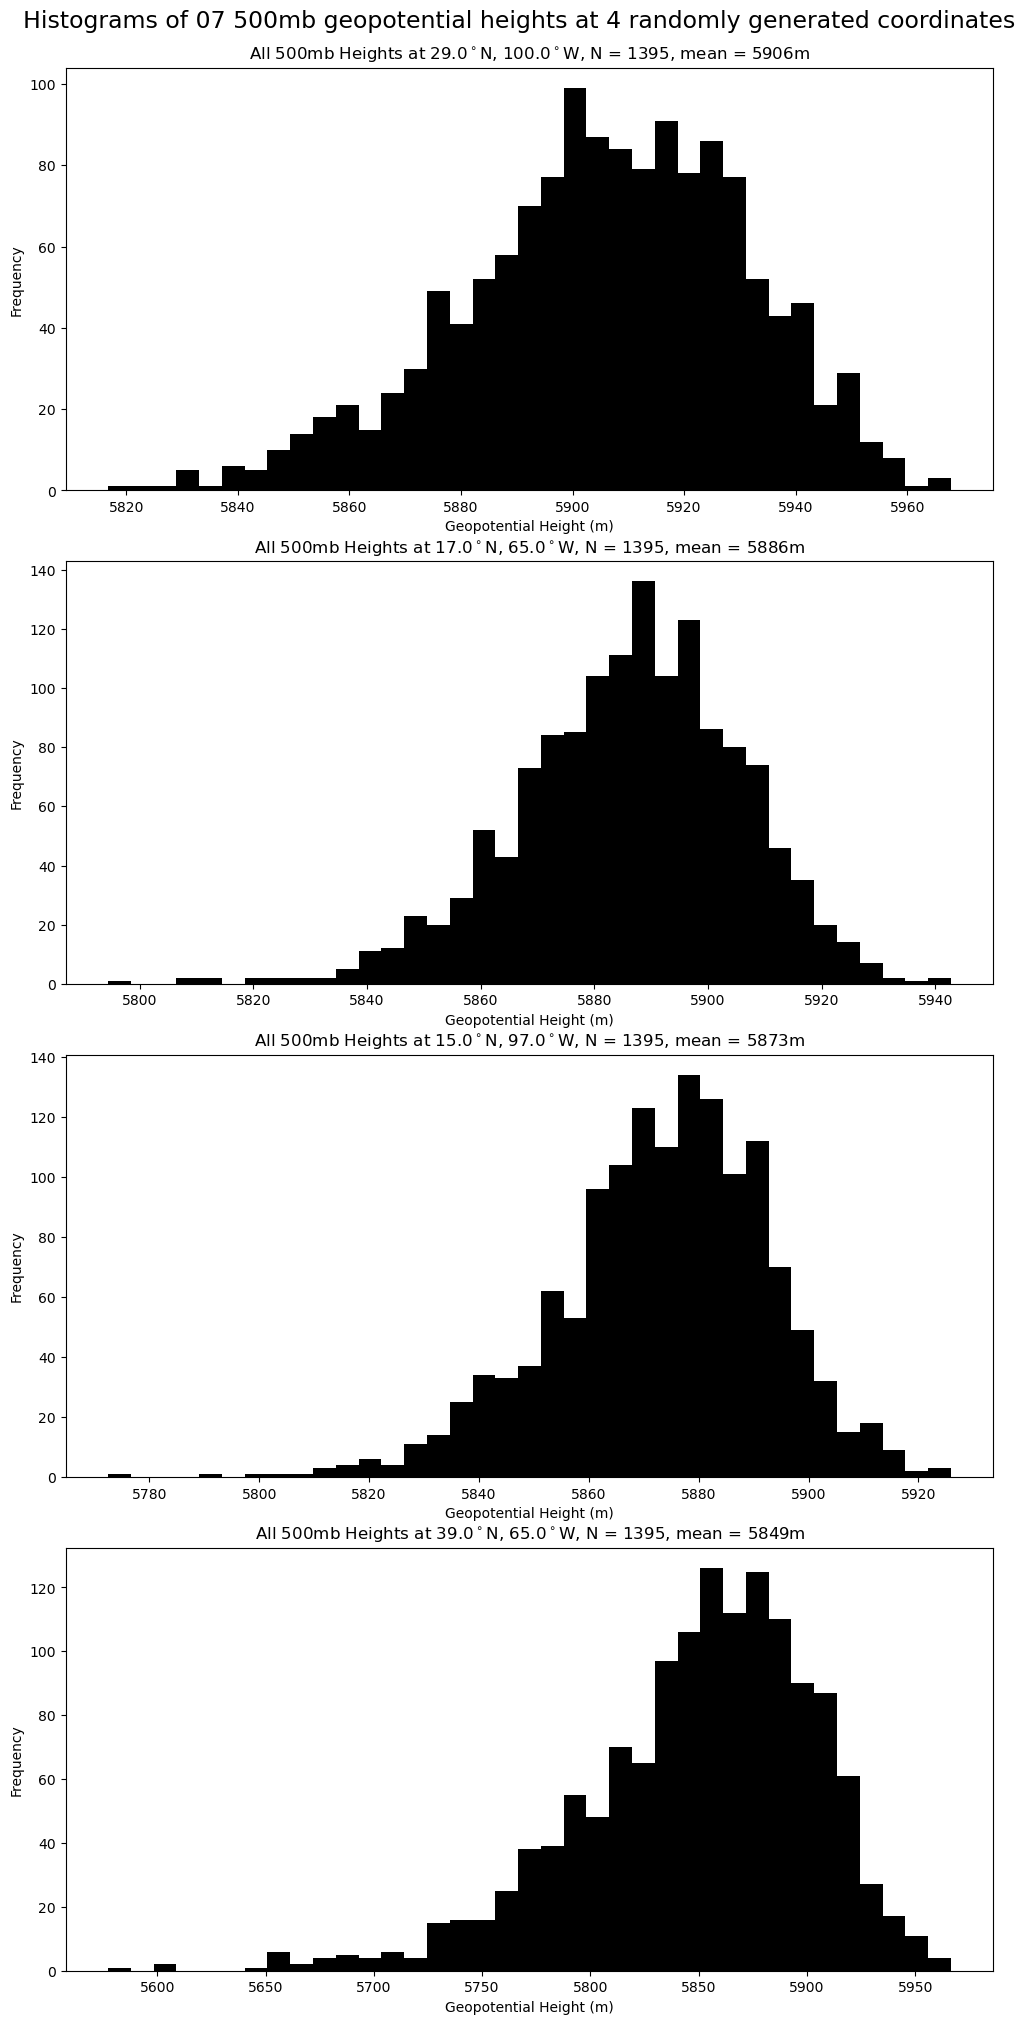

In [32]:
folder = r"C:\Users\nweat\OneDrive\School\Blocking Research\Geopotential Climatology"
month = "07"
plot_gph_histograms(folder, month)

In [15]:
def plot_gph_anomalies(day):
    ''' Creates a cartopy plot of geopotential height anomalies for the given day specified using the calculated monthly climatologies.
    All plots use data from 18z.
    Parameters:
    - day --> a string in the form yyyy_mm_dd to specify the day to plot the anomalies for.'''
    
    # filepath
    filepath = rf"C:\Users\nweat\Downloads\gph_anoms_{day}.nc"

    # open and retrieve the anomalies
    data = xr.open_dataset(filepath)
    z_anoms = data['z_anom']
    lats = data['latitude']
    lons = data['longitude']
    
    # open and retrieve data
    #Create the figure for the cartopy plot, specify the projection
    projection = ccrs.PlateCarree(central_longitude = 0)
    fig = plt.figure(figsize = (12,9))
    ax = fig.add_subplot(111, projection = projection)
    ax.set_title(f'Geopotential Height Anomalies on {day}', fontsize = 15)

    #Add some cartopy details to the first figure
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth = 0.5, edgecolor = 'black', zorder = 1)
    ax.add_feature(cfeature.LAKES, linewidth = 0.5, edgecolor = 'black', zorder = 2)
    ax.add_feature(cfeature.OCEAN, linewidth = 0.5, edgecolor = 'black', zorder = 1)
    ax.add_feature(cfeature.STATES, linewidth = 0.5, edgecolor = 'black', zorder = 2)

    #Add grid lines for latitude and longitude
    grid_lines = ax.gridlines(draw_labels = True, xlocs = [-105, -95, -85, -75, -65], ylocs = [35,45,55], linestyle = '--', color = 'white', zorder = 3)
    grid_lines.xlabel_style = {'size': 5, 'color': 'black'}
    grid_lines.ylabel_style = {'size': 5, 'color': 'black'}

    #Get rid of grid line labels on the top and right of the plot
    grid_lines.top_labels = False 
    grid_lines.right_labels = False 
       
    #Setup the height contours, colors, and colorbar
    cf = ax.contourf(lons, lats, z_anoms, norm = colors.CenteredNorm(), cmap = 'seismic', zorder = 1)
    cbar = plt.colorbar(cf, pad = 0.01, shrink = 0.72)
    cl = ax.contour(cf, colors = 'k', linewidths = 0.5, zorder = 1)
    cbar.add_lines(cl)
    cbar.set_label("Anomaly (m)")   

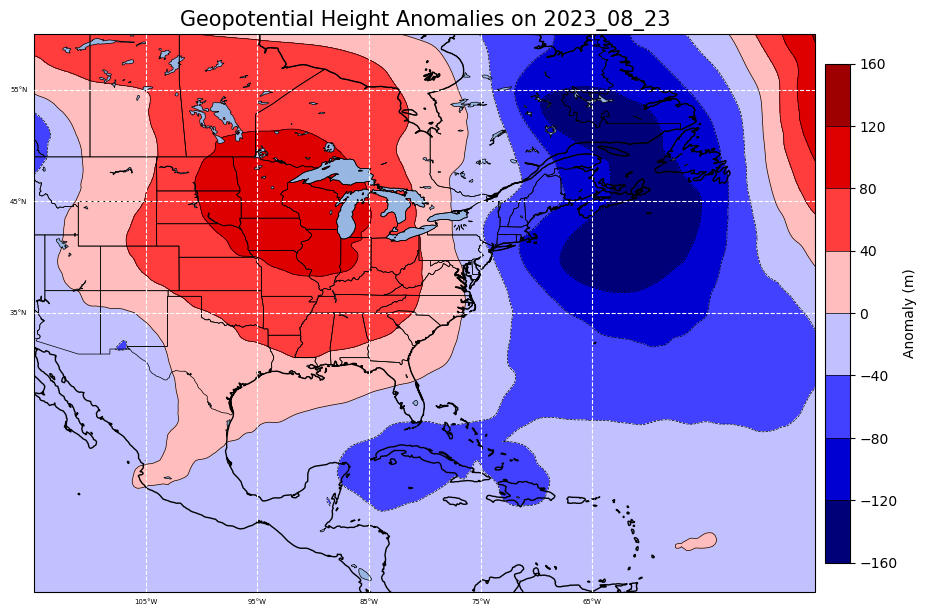

In [25]:
day = '2023_08_23'
plot_gph_anomalies(day)

In [6]:
data = xr.open_dataset(r"X:\dewhirst\blocking_indices\blocking indices\blocking_indices_2023_08_23.nc")
B_filt = data['B_filt'].sel(latitude = slice(50,25), longitude = slice(250,310))
B_raw = data['B_raw']

lats = data['latitude'].sel(latitude = slice(50,25))

lons = data['longitude']


<xarray.DataArray 'latitude' ()>
array(50., dtype=float32)
Coordinates:
    latitude  float32 50.0
<xarray.DataArray 'latitude' ()>
array(25., dtype=float32)
Coordinates:
    latitude  float32 25.0


In [8]:
B_max = np.max(B_raw)

# Get the coordinates of the maximum blocking index within the condition specified above
B_max_lat_idx = np.where(B_raw == B_max)[0][0]
B_max_lon_idx = np.where(B_raw == B_max)[1][0]

print(B_max_lat_idx)
print(B_max_lon_idx)

132
116


In [10]:
condition = (B_filt == 1)

# Get the area in B_raw where the above is true
constrained_B = B_raw.where(condition)

print(constrained_B)

<xarray.DataArray 'B_raw' (latitude: 101, longitude: 241)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.23094513, 0.21048018, 0.1896532 , ...,        nan,        nan,
               nan],
       [0.21200457, 0.19150153, 0.17137957, ...,        nan,        nan,
               nan],
       [0.19658917, 0.1763529 , 0.15672638, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 250.0 250.2 250.5 250.8 ... 309.5 309.8 310.0
